# Preprocessing:
**we will try**:
 to clean the data - fill nan value, generate new features.

 **desired output**:
 cleaned,prepared dataset



## 1. Import Libraries and Data

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [4]:
data_train = pd.read_csv("data/train.csv")
data_test =  pd.read_csv("data/test.csv")
data_all = pd.concat([data_train,data_test])
data_train.shape, data_test.shape, data_all.shape

((891, 12), (418, 11), (1309, 12))

In [5]:
data_train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


## 2. Clean The Data

### 2.1. Drop columns

In [6]:
drop_col = ['PassengerId','Ticket']
data_all.drop(columns=drop_col,inplace=True)

### 2.2 Fill missing values
- Embarked
- Fare
- Cabin
- Age

In [7]:
pd.DataFrame(data_all.isna().sum()).T

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
0,418,0,0,0,263,0,0,1,1014,2


- Embarked

In [8]:
# 1. Embarked
data_all[data_all['Embarked'].isna()]
# note: both passangers have farre = 80, Pclass =1

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
61,1.0,1,"Icard, Miss. Amelie",female,38.0,0,0,80.0,B28,NaN
829,1.0,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,80.0,B28,NaN


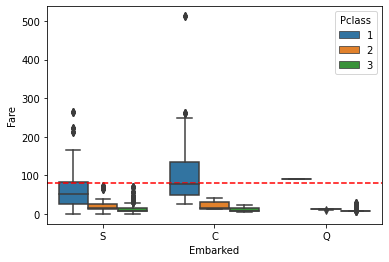

In [9]:
# replace with that?
sns.boxplot(x = 'Embarked',y = 'Fare', data = data_all,hue='Pclass')
plt.axhline(y=80, color='r', ls='--')
plt.show()
# note: as you can see the passangers they must be from Embarked C

In [10]:
# the passangers might be from the C embarked 
data_all['Embarked'].fillna('C',inplace=True)

- Fare

In [11]:
data_all[data_all['Fare'].isna()]
# note: passanger is from Pclass=3, Sex = male, Embarked=S

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked
152,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,NaN,NaN,S


In [12]:
data_all.groupby(['Pclass','Sex','Embarked'])['Fare'].median()
# note: it's Fare must be 8.05

Pclass  Sex     Embarked
1       female  C           83.15830
                Q           90.00000
                S           78.85000
        male    C           62.66875
                Q           90.00000
                S           35.50000
2       female  C           27.72080
                Q           12.35000
                S           23.00000
        male    C           15.04580
                Q           12.35000
                S           13.00000
3       female  C           14.45420
                Q            7.75000
                S           13.77500
        male    C            7.22920
                Q            7.75000
                S            8.05000
Name: Fare, dtype: float64

In [13]:
# as we can see people with pclass 3 with male gender and S class pay 8.05
data_all['Fare'].fillna(7.75,inplace=True)

- add Fare bins feature

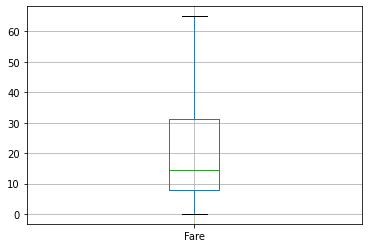

In [14]:
#create Fare bins
data_all[['Fare']].boxplot(showfliers=False)

In [15]:
max(data_all['Fare']), min(data_all['Fare'])

(512.3292, 0.0)

In [16]:
bins_Fare = [-100, 8, 31, 70, 600]
labels_Fare = ['cheap','medium','high','very_high']
data_all['Fare_bin'] = pd.cut(data_all['Fare'], bins = bins_Fare, labels=labels_Fare)
data_all['Fare_bin'].value_counts(normalize=True)*100

medium       47.211612
cheap        27.578304
high         13.292590
very_high    11.917494
Name: Fare_bin, dtype: float64

- Cabin

In [17]:
#what information can we get from Cabin?
data_all['Cabin_location'] = data_all['Cabin'].apply(lambda x: str(x)[0])
data_all.drop(columns=['Cabin'],inplace=True)

- Age

In [18]:
data_all.Age.mean()

29.881137667304014

- create a family size

In [19]:
#lets create family size first
data_all["Family_size"] = data_all['SibSp'] + data_all['Parch'] + 1
data_all['Family_size'].value_counts(normalize=True)*100

1     60.351413
2     17.952636
3     12.146677
4      3.284950
6      1.909855
5      1.680672
7      1.222307
11     0.840336
8      0.611154
Name: Family_size, dtype: float64

- create is_alone feature

In [20]:
#s he alone or not?
data_all['is_Alone'] = np.where(data_all['SibSp'] + data_all['Parch']==0,1,0)

- create Family size bins

In [21]:
#Family size in bins
def change_f_size(x):
  if x ==1:
    return 'single'
  elif x>=2 | x<= 4:
    return 'medium'
  else:
    return 'large'

data_all['Family_size'] = data_all['Family_size'].apply(change_f_size)
data_all['Family_size'].value_counts(normalize=True)*100

single    60.351413
medium    30.099312
large      9.549274
Name: Family_size, dtype: float64

- fill age nan values with mean value grouped by Pclass','Sex','Embarked','Family_size','Fare_bin'

In [22]:
data_all['Age_test'] = data_all['Age']
data_all['Age_test']  = data_all['Age_test'].fillna(data_all.groupby(['Pclass','Sex','Embarked','Family_size','Fare_bin'])['Age'].transform('mean'))
data_all['Age_test'] = data_all['Age_test'].fillna(data_all['Age_test'].mean())
data_all['Age_test'] = data_all['Age_test'].round()
data_all[data_all['Age'].isna()].head(10)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,Fare_bin,Cabin_location,Family_size,is_Alone,Age_test
5,0.0,3,"Moran, Mr. James",male,NaN,0,0,8.4583,Q,medium,n,single,1,30.0
17,1.0,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,13.0000,S,medium,n,single,1,33.0
19,1.0,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,7.2250,C,cheap,n,single,1,26.0
26,0.0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,7.2250,C,cheap,n,single,1,27.0
28,1.0,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,7.8792,Q,cheap,n,single,1,24.0
29,0.0,3,"Todoroff, Mr. Lalio",male,NaN,0,0,7.8958,S,cheap,n,single,1,29.0
31,1.0,1,"Spencer, Mrs. William Augustus (Marie Eugenie)",female,NaN,1,0,146.5208,C,very_high,B,medium,0,40.0
32,1.0,3,"Glynn, Miss. Mary Agatha",female,NaN,0,0,7.7500,Q,cheap,n,single,1,24.0
36,1.0,3,"Mamee, Mr. Hanna",male,NaN,0,0,7.2292,C,cheap,n,single,1,27.0
42,0.0,3,"Kraeff, Mr. Theodor",male,NaN,0,0,7.8958,C,cheap,n,single,1,27.0


In [23]:
data_all['Age'] = data_all['Age_test']
data_all.drop(columns=['Age_test'],inplace=True)

- get info from Title

In [24]:
data_all['Title'] = data_all['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())
data_all.drop(columns=['Name'],inplace=True)

In [25]:
data_all['Title'] = data_all['Title'].replace({'Mlle':'Miss','Ms':'Miss','Mmme':'Mrs'})

In [26]:
data_all['Title'].value_counts(normalize=True)*100

Mr              57.830405
Miss            20.168067
Mrs             15.049656
Master           4.660046
Rev              0.611154
Dr               0.611154
Col              0.305577
Major            0.152788
Jonkheer         0.076394
Capt             0.076394
the Countess     0.076394
Don              0.076394
Lady             0.076394
Sir              0.076394
Mme              0.076394
Dona             0.076394
Name: Title, dtype: float64

- filter low frequency values

In [27]:
#filter low frequency values and assign as others
def replace_low_pred_others(data_train,feature,precentage):
  return data_train[feature].mask(data_train[feature].map(data_train[feature].value_counts(normalize=True)*100) < precentage, 'Other_t')

data_all['Title'] = replace_low_pred_others(data_all,'Title',0.15)

In [28]:
data_all['Title'].value_counts(normalize=True)*100

Mr         57.830405
Miss       20.168067
Mrs        15.049656
Master      4.660046
Other_t     0.611154
Rev         0.611154
Dr          0.611154
Col         0.305577
Major       0.152788
Name: Title, dtype: float64

- create a bin for age

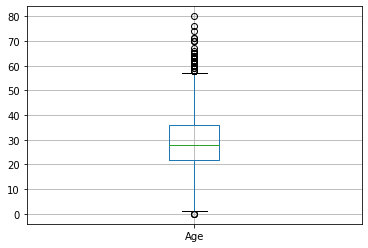

In [29]:
data_all[['Age']].boxplot()

In [30]:
bins_age = [-1, 10, 20, 50,120]
labels_age = ['baby','young','adult','elderly']
data_all['age_bin'] = pd.cut(data_all['Age'], bins = bins_age, labels=labels_age)
data_all['age_bin'].value_counts(normalize=True)*100

adult      71.122995
young      14.896868
elderly     7.410237
baby        6.569901
Name: age_bin, dtype: float64

In [31]:
data_all['Sex'] = data_all['Sex'].map({'female':1,"male":0})

In [32]:
pd.DataFrame(data_all.isna().sum()).T

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Fare_bin,Cabin_location,Family_size,is_Alone,Title,age_bin
0,418,0,0,0,0,0,0,0,0,0,0,0,0,0


In [33]:
data_all.shape

(1309, 14)

In [34]:
#sort columns
data_all_final = data_all[['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','is_Alone', 'Embarked','Fare_bin','Cabin_location','Family_size','Title','age_bin']]
data_all_final.shape

(1309, 14)

In [35]:
data_all_final.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,is_Alone,Embarked,Fare_bin,Cabin_location,Family_size,Title,age_bin
0,0.0,3,0,22.0,1,0,7.2500,0,S,cheap,n,medium,Mr,adult
1,1.0,1,1,38.0,1,0,71.2833,0,C,very_high,C,medium,Mrs,adult
2,1.0,3,1,26.0,0,0,7.9250,1,S,cheap,n,single,Miss,adult
3,1.0,1,1,35.0,1,0,53.1000,0,S,high,C,medium,Mrs,adult
4,0.0,3,0,35.0,0,0,8.0500,1,S,medium,n,single,Mr,adult
5,0.0,3,0,30.0,0,0,8.4583,1,Q,medium,n,single,Mr,adult
6,0.0,1,0,54.0,0,0,51.8625,1,S,high,E,single,Mr,elderly
7,0.0,3,0,2.0,3,1,21.0750,0,S,medium,n,large,Master,baby
8,1.0,3,1,27.0,0,2,11.1333,0,S,medium,n,medium,Mrs,adult
9,1.0,2,1,14.0,1,0,30.0708,0,C,medium,n,medium,Mrs,young


In [36]:
data_all_final.to_csv('data_filtered.csv',index=False)

## Future work:
- fill Cabin nan values using creating predictive model!
- other features generation can be done!